# Sprint 3

During the course we learned how to approach machine learning problems, we gained intuition and used multiple different algorithms. 

In the third and final sprint we decided to use these building to try and create a machine learning model end-to-end. We decided to put a lot of our focus on how the solution we would create could actually be used. Creating models in Jupyter notebook thought us how to experiment with machine learning models. But now we decided to go beyond the course so that we would learn how the models we learned to create could actually be used by users.

This meant that during Sprint 3 we would need to do the following things:
* Define a problem to solve.
* Find a way to solve our problem.
* Make our solution available for actual users.

> **note**: Since we are using multiple cloud tools througout the notebook we recommend uploading this file to a google colab notebook.

>**note**: Some command executions require authentication. These will throw errors, however we put them in the notebook for documentation purposes.

In [2]:
!pip install gcsfs
!conda install --yes --prefix {sys.prefix} nltk bs4 gensim

import sys
import os 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

import multiprocessing
from gensim.sklearn_api import D2VTransformer

from sklearn.model_selection import train_test_split


%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub
import shutil

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

/bin/bash: conda: command not found


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
TensorFlow 1.x selected.


## Defining a problem to solve

### Idea 1

The following section will describe the first idea we had and the steps we took to find out that the data was not what we expected it to be. 

**Idea 1**: Can we predict the quality (Consumer disputed?)  of an answer (Company response to consumer + Timely response) based upon the customers’ messages (Consumer complaint narrative) and the context (Product + Issue)?

#### Reading the data

Our data is stored in Google Cloud Storage within the Google Cloud Platform. This requires some initial setup.

In [3]:
PROJECT = 'appliedml-270208'
BUCKET = 'applied_machine_learning_bucket'
REGION = 'europe-west1'

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

!gcloud config set project $PROJECT
!gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


Lets read the data:

In [0]:
raw_data = pd.read_csv('gs://'+BUCKET+'/complaints-2020-01-22_08_24.csv')
#raw_data = pd.read_csv('complaints-2020-01-22_08_24.csv')

#### Selecting columns

The selection of the columns was based upon our knowledge gained from the EDA phases in previous sprints.

In [0]:
relevant_data = raw_data[[
    'Consumer complaint narrative', 
    'Company public response',
    'Company response to consumer',
    'Timely response?', 
    'Consumer disputed?', 
    'Product', 
    'Issue']]

#relevant_data.head()

As seen below the Company response to consumer column is a categorical column. We found this out by doing EDA. We were expecting a text values similar to the Consumer complaint narrative column.

In [6]:
relevant_data['Company response to consumer'].unique()

array(['Closed with explanation', 'Closed with non-monetary relief',
       'Closed with monetary relief', 'Untimely response', 'Closed',
       'In progress', 'None'], dtype=object)

Since the data was not what we expected we decided to come up with a new idea. We are aware we could have used this feature as a categorical column and tried to solve the problem. However, we decided to pivot to a new idea.

### Final Idea

The following section will describe the final idea we decided upon to solve. 

**Idea**: Can we predict the type of issue (Issue) upon the message (Consumer complaint narrative) sent to the company (Company) and the relevant product (Product)? 

## Finding a way to solve our problem

Now that our problem (classification) was defined we experimented with different approaches to solve this problem.

### Distribution analysis of issues

Since we started from a new idea instead of optimizing a previously made solution, we needed a bit more exploratory data analysis.

161


Text(0.5, 1.0, 'issues')

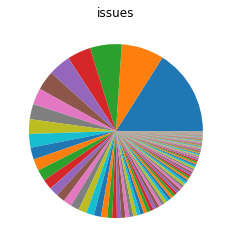

In [7]:
print(len(raw_data['Issue'].unique()))

issues = raw_data["Issue"].value_counts()
patches = plt.pie(issues.values)
plt.title("issues")

We can see that the issue occurance is not balanced at all. This suggested to us that we would need to balance our training data.

We can see that we have 161 classes that are very skewed. Since we have a lot of classes with few to almost no records we decide to work with a cutoff. Issues that have less records than the cutoff value will be grouped together in the ‘Unknown’ class.

### Transform the data

In [0]:
KEEP_LOWER_BOUDNARY = 2000

def define_keeps(df):
    counts = df['Issue'].value_counts()
    names = df['Issue'].value_counts().index
    keep = [ names[i] for i, issue_count in enumerate(counts) if issue_count > KEEP_LOWER_BOUDNARY ]

    return keep

KEEPS = define_keeps(raw_data)

cutoff_data = raw_data.copy()
cutoff_data.loc[~cutoff_data['Issue'].isin(KEEPS), 'Issue'] = "Unknown"

In [11]:
print(f'Issues that are kept: {cutoff_data.loc[cutoff_data["Issue"].isin(KEEPS),:].shape}')
print(f'Issues that are moved to Unknown: {cutoff_data.loc[~cutoff_data["Issue"].isin(KEEPS),:].shape}')

Issues that are kept: (437347, 18)
Issues that are moved to Unknown: (48354, 18)


We prefer not to have whitespace in the feature names. That’s why we executed the following code:

In [0]:
cutoff_data['Message'] = cutoff_data['Consumer complaint narrative']

### Cleaning the data

We decided to clean our data since this would improve results.

In [0]:
stopWords = stopWords = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
  
def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        word = stemmer.stem(word)
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [0]:
cleaned_data = cutoff_data.copy()
cleaned_data['Message'] = cleaned_data['Message'].apply(preprocessing)

### Defining constants

At this point, the data has the desired shape. This lets us define constants that we can use throughout the notebook.

In [0]:
CSV_COLUMNS = ['Product', 'Company', 'Message', 'Issue']
CSV_FEATURES = ['Product', 'Company', 'Message']
TARGET_LABEL = 'Issue'
DEFAULTS = [['Unknown'], ['Unknown'], ['Unknown']]

PROD_VOCAB = np.append(cleaned_data['Product'].unique(), 'Unknown')
COMP_VOCAB = np.append(cleaned_data['Company'].unique(), 'Unknown')
ISS_VOCAB = cleaned_data['Issue'].unique()

### Selecting relevant columns

There is no need to hold on to irrelevant columns.

In [19]:
selected_data = cleaned_data[CSV_COLUMNS]
selected_data.head()

,Product,Company,Message,Issue
0,"Credit reporting, credit repair services, or o...",Experian Information Solutions Inc.,complain mani time credit report experian inac...,Credit monitoring or identity theft protection...
1,Debt collection,"Ideal Collection Services, Inc.",pleas review current fraud account also fraudu...,False statements or representation
2,Debt collection,"ONEMAIN FINANCIAL HOLDINGS, LLC.",call multipl time year debt occur dure previou...,Attempts to collect debt not owed
3,Debt collection,"Diversified Consultants, Inc.",sent letter compani valid debt special ask att...,Attempts to collect debt not owed
4,"Credit reporting, credit repair services, or o...","ClearOne Advantage, LLC",appli debt relief product account execut name ...,Improper use of your report


### Train-Eval-Test split

We divided our data into three parts: training data (80%), evaluation data (10%) and testing data (10%). 

In [0]:
x_train, x_test, y_train, y_test = train_test_split(selected_data[CSV_FEATURES], selected_data[TARGET_LABEL], test_size=0.2)
x_eval, x_test, y_eval, y_test  = train_test_split(x_test, y_test, test_size=0.5)

We reassemble the dataframes since they might be necessary at a later point. 

In [0]:
train_data = x_train.copy(deep=True)
train_data['Issue'] = y_train.values

eval_data = x_eval.copy(deep=True)
eval_data['Issue'] = y_eval.values

test_data = x_test.copy(deep=True)
test_data['Issue'] = y_test.values

When checking for null values in the dataframe we found descrepencies before and after the train_test_split. This lead to issues further in the notebook so we filter them out here.

In [136]:
print('Amount of null values before train-eval-test split: {}'.format(selected_data['Message'].isnull().values.sum()))
print('Amount of null values after train-eval-test split (train): {}'.format(train_data['Message'].isnull().values.sum()))
print('Amount of null values before train-eval-test split (eval): {}'.format(eval_data['Message'].isnull().values.sum()))
print('Amount of null values before train-eval-test split (test): {}'.format(test_data['Message'].isnull().values.sum()))

Amount of null values before train-eval-test split: 0
Amount of null values after train-eval-test split (train): 0
Amount of null values before train-eval-test split (eval): 0
Amount of null values before train-eval-test split (test): 4


In [137]:
train_data = train_data.iloc[np.where(~train_data['Message'].isnull().values)[0], :]
eval_data = eval_data.iloc[np.where(~eval_data['Message'].isnull().values)[0], :]
test_data = test_data.iloc[np.where(~test_data['Message'].isnull().values)[0], :]

print('Amount of null values before train-eval-test split: {}'.format(selected_data['Message'].isnull().values.sum()))
print('Amount of null values after train-eval-test split (train): {}'.format(train_data['Message'].isnull().values.sum()))
print('Amount of null values before train-eval-test split (eval): {}'.format(eval_data['Message'].isnull().values.sum()))
print('Amount of null values before train-eval-test split (test): {}'.format(test_data['Message'].isnull().values.sum()))

Amount of null values before train-eval-test split: 0
Amount of null values after train-eval-test split (train): 0
Amount of null values before train-eval-test split (eval): 0
Amount of null values before train-eval-test split (test): 0


### Balancing the training data

The balancing of our training data should reduce the chances of the model collapsing into simply predicting the most prevalent column.

This is the original situation after cutoff:

[Text(0, 0, 'Improper use of your report'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'Incorrect information on your report'),
 Text(0, 0, 'Loan servicing, payments, escrow account'),
 Text(0, 0, 'Written notification about debt'),
 Text(0, 0, 'Unable to get credit report/credit score'),
 Text(0, 0, 'Managing an account'),
 Text(0, 0, 'Advertising and marketing, including promotional offers'),
 Text(0, 0, 'Improper contact or sharing of info'),
 Text(0, 0, 'Communication tactics'),
 Text(0, 0, 'Fraud or scam'),
 Text(0, 0, 'Struggling to pay mortgage'),
 Text(0, 0, 'Applying for a mortgage or refinancing an existing mortgage'),
 Text(0, 0, 'Problem when making payments'),
 Text(0, 0, 'Problems when you are unable to pay'),
 Text(0, 0, 'False statements or representation'),
 Text(0, 0, 'Opening an account'),
 Text(0, 0, "Cont'd attempts collect debt not owed"),
 Text(0, 0, 'Account opening, closing, or management'),
 Text(0, 0, 'Incorrect information on credit report'),
 Text(0, 0, 'Dealing w

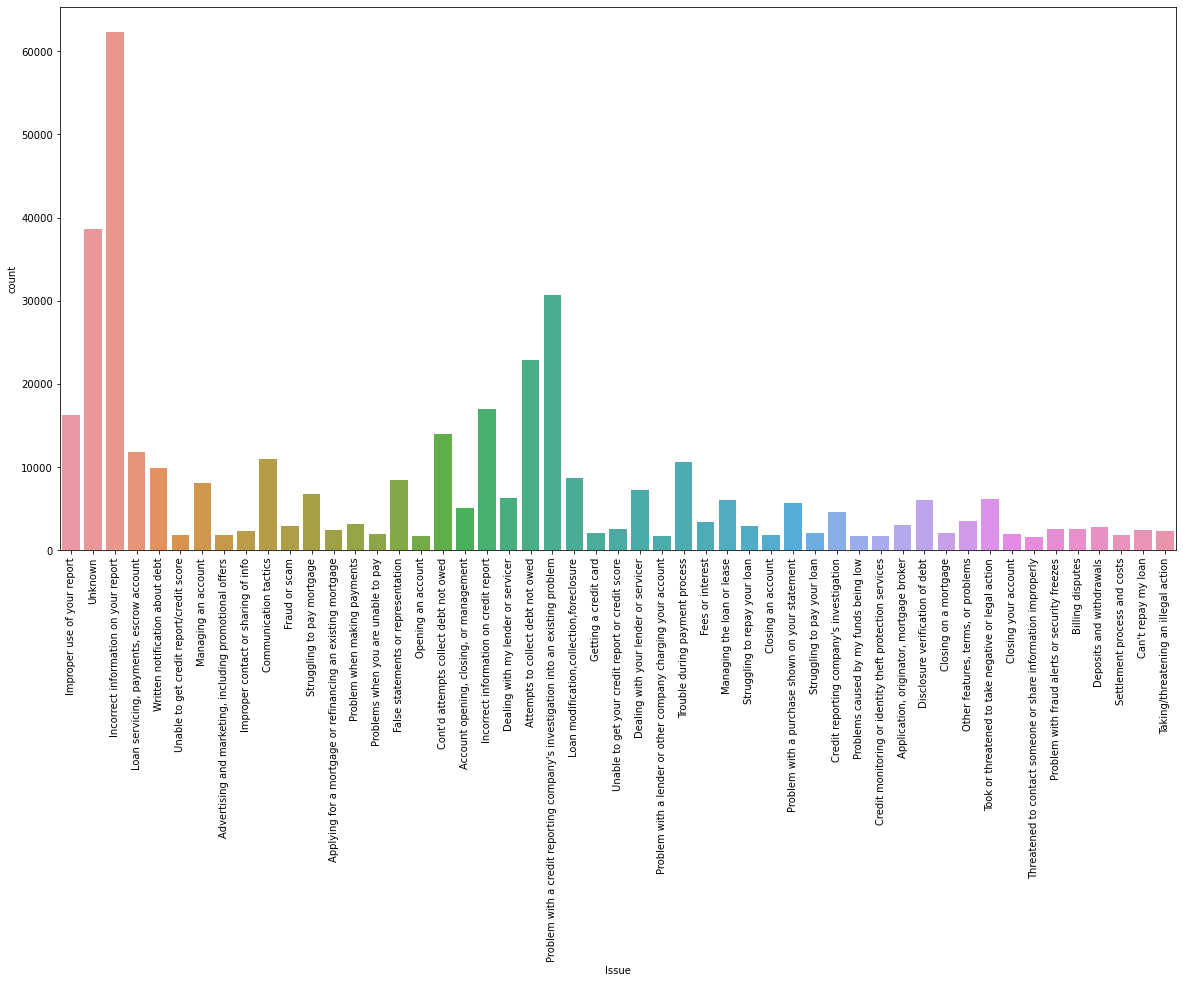

In [0]:
fig = plt.figure(figsize=(20,10))
chart = sns.countplot('Issue', data=train_data)
labels = chart.get_xticklabels()
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

We decide to create two different sizes of balanced datasets so we could experiment with both. The balancing was realized by using sampling and in some cases oversampling.

In [0]:
# Define boundaries for sampling
BALANCE_SMALL_UPPER = 1000
BALANCE_SMALL_LOWER = 500
BALANCE_LARGER_UPPER = 7500
BALANCE_LARGER_LOWER = 5000

def create_balanced_dataset(df, lower, upper):

    balanced_data = pd.DataFrame()

    for issue in ISS_VOCAB:
        if df[df['Issue'] == issue].shape[0] > upper:
            # Sample when more available than upper boundary
            balanced_data = pd.concat([df[df['Issue'] == issue].sample(upper), balanced_data])
        if df[df['Issue'] == issue].shape[0] <= lower and df[df['Issue'] == issue].shape[0] > 0:
            # Oversample up to lower boundary when to few available
            balanced_data = pd.concat([df[df['Issue'] == issue].sample(lower, replace=True), balanced_data])

    return balanced_data

balanced_train_small = create_balanced_dataset(train_data, BALANCE_SMALL_LOWER, BALANCE_SMALL_UPPER)
balanced_train_larger = create_balanced_dataset(train_data, BALANCE_LARGER_LOWER, BALANCE_LARGER_UPPER)

The results of the balacing are the following: 

[Text(0, 0, 'Deposits and withdrawals'),
 Text(0, 0, 'Problems caused by my funds being low'),
 Text(0, 0, 'Improper contact or sharing of info'),
 Text(0, 0, 'Application, originator, mortgage broker'),
 Text(0, 0, 'Problems when you are unable to pay'),
 Text(0, 0, "Credit reporting company's investigation"),
 Text(0, 0, 'Unable to get credit report/credit score'),
 Text(0, 0, 'Dealing with my lender or servicer'),
 Text(0, 0, 'Billing disputes'),
 Text(0, 0, 'Incorrect information on credit report'),
 Text(0, 0, 'Account opening, closing, or management'),
 Text(0, 0, "Can't repay my loan"),
 Text(0, 0, 'Disclosure verification of debt'),
 Text(0, 0, "Cont'd attempts collect debt not owed"),
 Text(0, 0, 'Settlement process and costs'),
 Text(0, 0, 'Taking/threatening an illegal action'),
 Text(0, 0, 'Loan modification,collection,foreclosure'),
 Text(0, 0, 'Loan servicing, payments, escrow account'),
 Text(0, 0, 'Applying for a mortgage or refinancing an existing mortgage'),
 Text(0, 

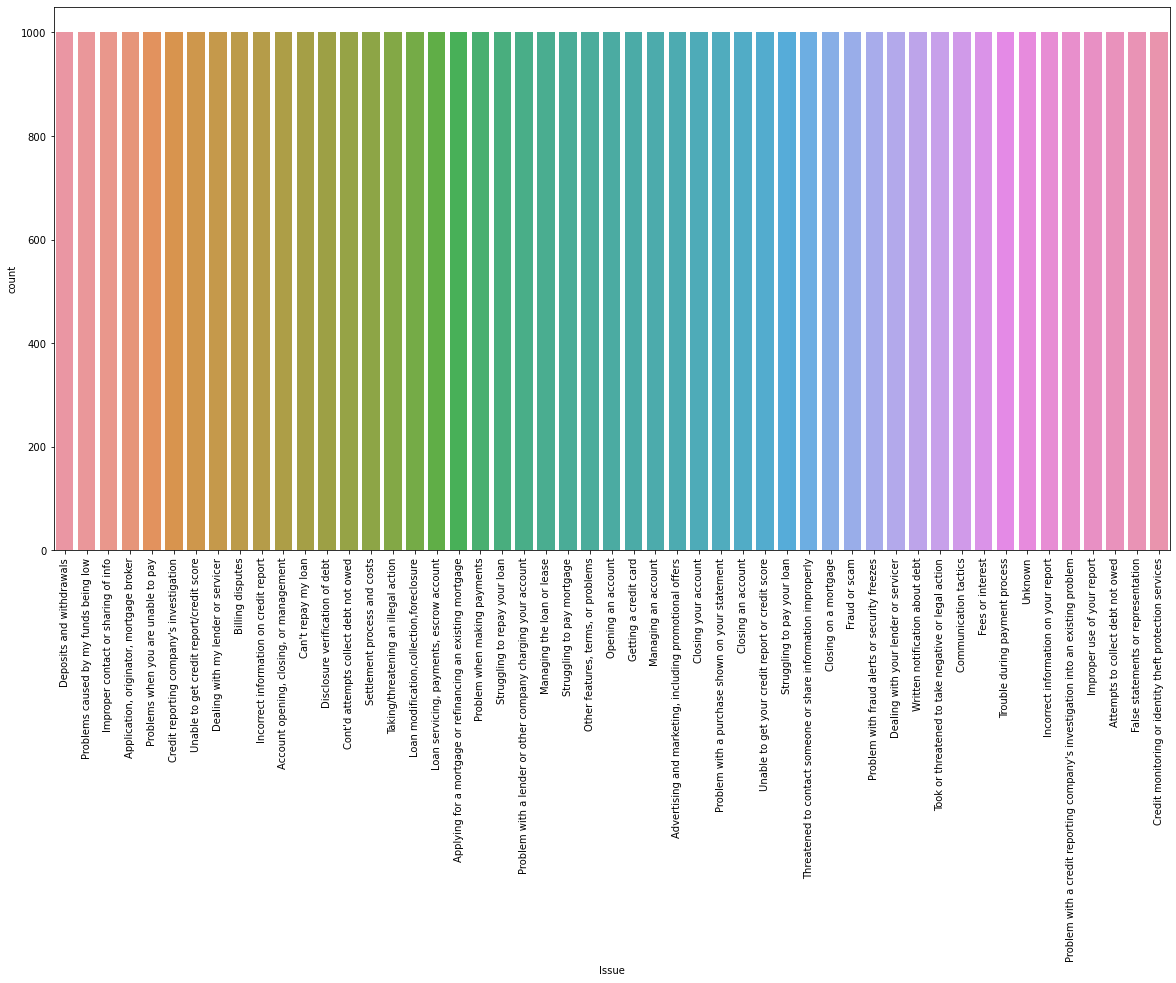

In [0]:
# Small balanced dataset
fig = plt.figure(figsize=(20,10))
chart = sns.countplot('Issue', data=balanced_train_small)
labels = chart.get_xticklabels()
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

[Text(0, 0, 'Deposits and withdrawals'),
 Text(0, 0, 'Problems caused by my funds being low'),
 Text(0, 0, 'Improper contact or sharing of info'),
 Text(0, 0, 'Application, originator, mortgage broker'),
 Text(0, 0, 'Problems when you are unable to pay'),
 Text(0, 0, "Credit reporting company's investigation"),
 Text(0, 0, 'Unable to get credit report/credit score'),
 Text(0, 0, 'Billing disputes'),
 Text(0, 0, 'Incorrect information on credit report'),
 Text(0, 0, "Can't repay my loan"),
 Text(0, 0, "Cont'd attempts collect debt not owed"),
 Text(0, 0, 'Settlement process and costs'),
 Text(0, 0, 'Taking/threatening an illegal action'),
 Text(0, 0, 'Loan modification,collection,foreclosure'),
 Text(0, 0, 'Loan servicing, payments, escrow account'),
 Text(0, 0, 'Applying for a mortgage or refinancing an existing mortgage'),
 Text(0, 0, 'Problem when making payments'),
 Text(0, 0, 'Struggling to repay your loan'),
 Text(0, 0, 'Problem with a lender or other company charging your account

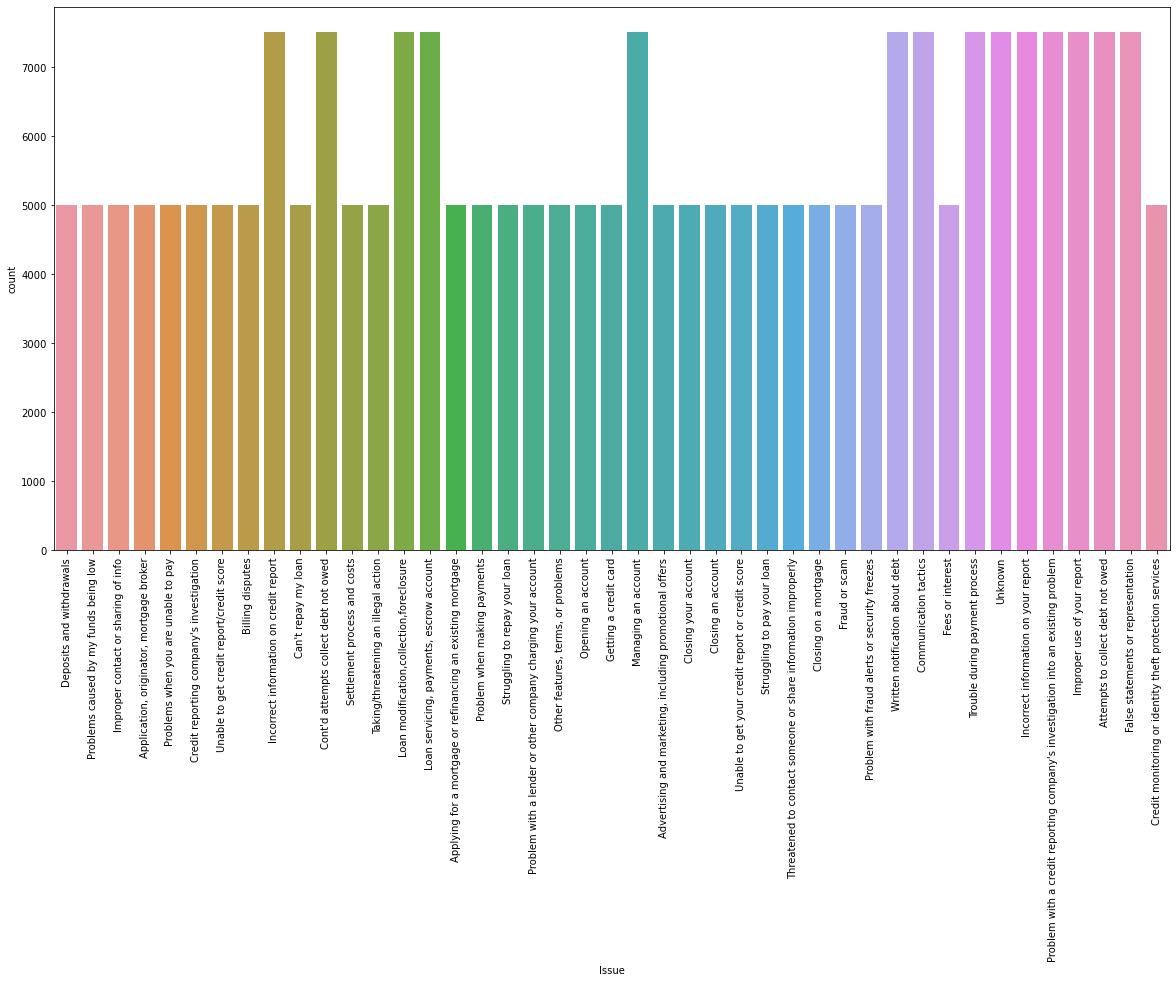

In [0]:
# Small balanced dataset
fig = plt.figure(figsize=(20,10))
chart = sns.countplot('Issue', data=balanced_train_larger)
labels = chart.get_xticklabels()
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

### Storing the processed data

Storing the processed data allowed us to skip the steps above when appropriate.

In [0]:
!mkdir data

In [0]:
train_data.to_csv('./data/train_data.csv', index=False)
eval_data.to_csv('./data/eval_data.csv', index=False)
test_data.to_csv('./data/test_data.csv', index=False)
balanced_train_small.to_csv('./data/balanced_train_small.csv', index=False)
balanced_train_larger.to_csv('./data/balanced_train_larger.csv', index=False)

We'll store a remote version of these files. This ensures that the previous steps can be skipped without any issues (on any machine). 

In [0]:
train_data.to_csv('gs://{}/preproc/train_data.csv'.format(BUCKET), index=False)
eval_data.to_csv('gs://{}/preproc/eval_data.csv'.format(BUCKET), index=False)
test_data.to_csv('gs://{}/preproc/test_data.csv'.format(BUCKET), index=False)
balanced_train_small.to_csv('gs://{}/preproc/balanced_train_small.csv'.format(BUCKET), index=False)
balanced_train_larger.to_csv('gs://{}/preproc/balanced_train_larger.csv'.format(BUCKET), index=False)

Let's check if the remote storing to Google Cloud Storage was successful.



In [4]:
!gsutil ls gs://$BUCKET/preproc

gs://applied_machine_learning_bucket/preproc/balanced_train_larger.csv
gs://applied_machine_learning_bucket/preproc/balanced_train_small.csv
gs://applied_machine_learning_bucket/preproc/eval_data.csv
gs://applied_machine_learning_bucket/preproc/test_data.csv
gs://applied_machine_learning_bucket/preproc/train_data.csv


### Retrieving the remote (preprocessed) data

Executing this section allows skipping of all previous preprocessing steps.

In [5]:
!gsutil cp -R gs://$BUCKET/preproc .

Copying gs://applied_machine_learning_bucket/preproc/balanced_train_larger.csv...
Copying gs://applied_machine_learning_bucket/preproc/balanced_train_small.csv...
Copying gs://applied_machine_learning_bucket/preproc/eval_data.csv...
Copying gs://applied_machine_learning_bucket/preproc/test_data.csv...
- [4 files][252.2 MiB/252.2 MiB]   14.1 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://applied_machine_learning_bucket/preproc/train_data.csv...
| [5 files][492.2 MiB/492.2 MiB]   18.7 MiB/s                                   
Operation completed over 5 objects/492.2 MiB.                                    


In [0]:
train_data = pd.read_csv('./preproc/train_data.csv')
eval_data = pd.read_csv('./preproc/eval_data.csv')
test_data = pd.read_csv('./preproc/test_data.csv')
balanced_train_small = pd.read_csv('./preproc/balanced_train_small.csv')
balanced_train_larger = pd.read_csv('./preproc/balanced_train_larger.csv')

CSV_COLUMNS = ['Product', 'Company', 'Message', 'Issue']
CSV_FEATURES = ['Product', 'Company', 'Message']
TARGET_LABEL = 'Issue'
DEFAULTS = [['Unknown'], ['Unknown'], ['Unknown']]

PROD_VOCAB = np.append(train_data['Product'].unique(), 'Unknown')
PROD_VOCAB = np.append(PROD_VOCAB, eval_data['Product'].unique())
PROD_VOCAB = np.append(PROD_VOCAB, test_data['Product'].unique())
PROD_VOCAB = list(set(PROD_VOCAB))

COMP_VOCAB = np.append(train_data['Company'].unique(), 'Unknown')
COMP_VOCAB = np.append(COMP_VOCAB, eval_data['Company'].unique())
COMP_VOCAB = np.append(COMP_VOCAB, test_data['Company'].unique())
COMP_VOCAB = list(set(COMP_VOCAB))

ISS_VOCAB = np.append(train_data['Issue'].unique(), 'Unknown')
ISS_VOCAB = np.append(ISS_VOCAB, eval_data['Issue'].unique())
ISS_VOCAB = np.append(ISS_VOCAB, test_data['Issue'].unique())
ISS_VOCAB = list(set(ISS_VOCAB))

### Creating a Proof of Concept

Since we wanted to test our theory, we decided to create a Proof of Concept machine learning model before taking the steps to productionize the model. First we will analyze how well a basic NN performs with just the doc2vec model. Afterwards we add company names and products to see if the model gives better predictions. 

#### Sample dataset

In order to create a local model sampling is a good idea to minimize the load on our machines. 

In [0]:
subset = balanced_train_larger.sample(50000)


#### Feature extraction

We need to make the categorical columns and the textual column understandable for a machine. For the categorical columns we used one-hot-encoding. Previous sprints deterimend that Doc2Vec feature extraction works well, we decided to use this during Sprint 3 as well.

In [0]:
def one_hot_encode(df):
    comp_1he = pd.get_dummies(df['Company'])
    prod_1he = pd.get_dummies(df['Product'])
    targets_1he = pd.get_dummies(df['Issue'])

    return comp_1he, prod_1he, targets_1he

comp_1he, prod_1he, targets_1he = one_hot_encode(subset)

In [147]:
def doc2vec(df):
    listOfDocsAsListOfStrings = [doc for doc in (row.split() for row in df['Message'])]
    model = D2VTransformer(size=250, window=5, min_count=2, workers=multiprocessing.cpu_count())
    transformed = model.fit_transform(listOfDocsAsListOfStrings)
    return transformed

transformed = doc2vec(subset)

print(transformed.shape)
print(comp_1he.shape)
print(prod_1he.shape)

(50000, 250)
(50000, 2250)
(50000, 18)


#### Keras Model

Since NLP is usually preformed with neural networks we decided to try this approach as well. We used Keras to create a Proof of Concept model due to its ease of development.

The PoC keras model is very basic. It has two hidden layers, each having 256 nodes. The output shape is of course defined by the number of issues. The input shape depends on the data fed. There will be no hyperparameter tuning at all. A basic SGD will be used as our optimizer and categorical crossentropy will be used as the loss function. 

In [0]:
def createDataSets(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)

    return x_train,x_val,x_test,y_train,y_val,y_test

In [0]:
def createModel(optimizer,loss, input_shape, output_shape):

    print(output_shape)
    
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(input_shape[1],)))
    model.add(Dense(256, activation='relu'))
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(output_shape[1], activation='softmax'))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
def trainModel(model, x, y, batch_size=64, epochs=10):
    x_train,x_val,x_test,y_train,y_val,y_test = createDataSets(x,y)
    
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, y_val))
    return history, x_test,y_test

In [0]:
def validateModel(history, score):
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

The first model will only use the doc2vec data as input data. This will give us a base truth. Later on when adding new data, we can see if the added data helps improvve the model. If the model would perform worse afterwards, we should fall back to just using the doc2vec data.

In [0]:
y = targets_1he
x = transformed

(50000, 43)
Epoch 1/10
493/493 [==============================] - 2s 4ms/step - loss: 3.6752 - accuracy: 0.0665 - val_loss: 3.5112 - val_accuracy: 0.1169
Epoch 2/10
493/493 [==============================] - 2s 4ms/step - loss: 3.1209 - accuracy: 0.1680 - val_loss: 2.8290 - val_accuracy: 0.2231
Epoch 3/10
493/493 [==============================] - 2s 4ms/step - loss: 2.6218 - accuracy: 0.2464 - val_loss: 2.5300 - val_accuracy: 0.2729
Epoch 4/10
493/493 [==============================] - 2s 4ms/step - loss: 2.4180 - accuracy: 0.2890 - val_loss: 2.4348 - val_accuracy: 0.2826
Epoch 5/10
493/493 [==============================] - 2s 4ms/step - loss: 2.3153 - accuracy: 0.3157 - val_loss: 2.3464 - val_accuracy: 0.3100
Epoch 6/10
493/493 [==============================] - 2s 4ms/step - loss: 2.2480 - accuracy: 0.3332 - val_loss: 2.3124 - val_accuracy: 0.3226
Epoch 7/10
493/493 [==============================] - 2s 4ms/step - loss: 2.1990 - accuracy: 0.3475 - val_loss: 2.2965 - val_accuracy: 0

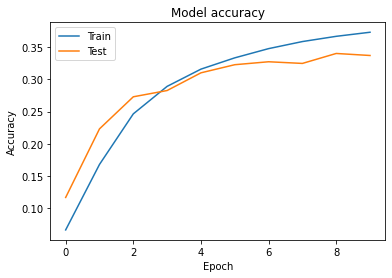

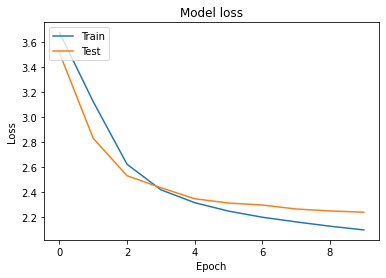

In [153]:
model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape, y.shape)

history, x_test,y_test = trainModel(model,x,y)

score = model.evaluate(x_test, y_test, verbose=0)
validateModel(history,score)

We get an accuracy of about 30+% when only using the dov2vec data with the NN. Let's see how much this improves by adding company names.

(50000, 43)
Epoch 1/10
493/493 [==============================] - 4s 9ms/step - loss: 3.6070 - accuracy: 0.0759 - val_loss: 3.2050 - val_accuracy: 0.1357
Epoch 2/10
493/493 [==============================] - 4s 8ms/step - loss: 2.7715 - accuracy: 0.1830 - val_loss: 2.4938 - val_accuracy: 0.2180
Epoch 3/10
493/493 [==============================] - 4s 8ms/step - loss: 2.3467 - accuracy: 0.2672 - val_loss: 2.2596 - val_accuracy: 0.2811
Epoch 4/10
493/493 [==============================] - 4s 8ms/step - loss: 2.1582 - accuracy: 0.3130 - val_loss: 2.1454 - val_accuracy: 0.3049
Epoch 5/10
493/493 [==============================] - 4s 8ms/step - loss: 2.0474 - accuracy: 0.3447 - val_loss: 2.0676 - val_accuracy: 0.3360
Epoch 6/10
493/493 [==============================] - 4s 8ms/step - loss: 1.9740 - accuracy: 0.3674 - val_loss: 2.0326 - val_accuracy: 0.3411
Epoch 7/10
493/493 [==============================] - 4s 8ms/step - loss: 1.9128 - accuracy: 0.3866 - val_loss: 1.9963 - val_accuracy: 0

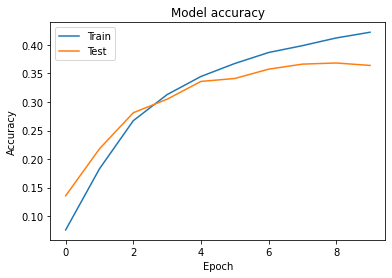

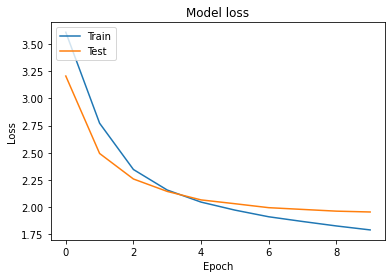

In [154]:
x = np.append(transformed, comp_1he.to_numpy(),axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

The basic keras NN improves with about 5% by adding company names. This is not as much as we expected since companies and certain issues seemed to be related, given a company's business model ect.

We will now check how good the model performs when adding product categories to the dov2vec model.

(50000, 43)
Epoch 1/10
493/493 [==============================] - 2s 4ms/step - loss: 2.5765 - accuracy: 0.2377 - val_loss: 1.6705 - val_accuracy: 0.3431
Epoch 2/10
493/493 [==============================] - 2s 4ms/step - loss: 1.5788 - accuracy: 0.3642 - val_loss: 1.5014 - val_accuracy: 0.3834
Epoch 3/10
493/493 [==============================] - 2s 4ms/step - loss: 1.4544 - accuracy: 0.4208 - val_loss: 1.4098 - val_accuracy: 0.4369
Epoch 4/10
493/493 [==============================] - 2s 4ms/step - loss: 1.3742 - accuracy: 0.4625 - val_loss: 1.3479 - val_accuracy: 0.4851
Epoch 5/10
493/493 [==============================] - 2s 4ms/step - loss: 1.3231 - accuracy: 0.4831 - val_loss: 1.3235 - val_accuracy: 0.4971
Epoch 6/10
493/493 [==============================] - 2s 4ms/step - loss: 1.2866 - accuracy: 0.5043 - val_loss: 1.3063 - val_accuracy: 0.4954
Epoch 7/10
493/493 [==============================] - 2s 4ms/step - loss: 1.2598 - accuracy: 0.5158 - val_loss: 1.2790 - val_accuracy: 0

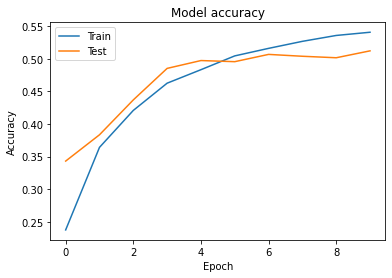

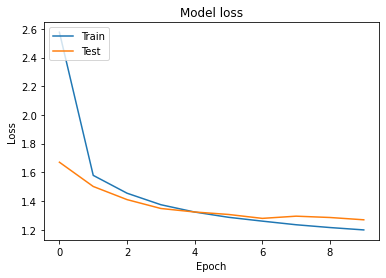

In [155]:
x = np.append(transformed, prod_1he.to_numpy(),axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

Adding products seems to give a way better performance. The model has about 50% accuracy now.

We wonder if the model now makes predictions solely on product and company, since it might be possible that those predict issues way better than the dov2vec model.


In [0]:
x = np.append(comp_1he.to_numpy(), prod_1he.to_numpy(),axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

We still get an accuracy of 30%.  The loss function only improves with very minor steps compared to before, this means there's just not enough meaningful data to train the model with anymore. Since the accuracy is 30% and the model can not be trained further, we conclude that  there's no way the model can tell exactly what issue it's going to be depending on company and product. It is clear that the doc2vec model is very much needed for better predictions. 


Lastly we check how the model performs when adding all the features:


(50000, 43)
Epoch 1/10
493/493 [==============================] - 4s 8ms/step - loss: 2.6752 - accuracy: 0.2160 - val_loss: 1.7281 - val_accuracy: 0.3094
Epoch 2/10
493/493 [==============================] - 4s 8ms/step - loss: 1.6069 - accuracy: 0.3526 - val_loss: 1.5715 - val_accuracy: 0.3554
Epoch 3/10
493/493 [==============================] - 4s 9ms/step - loss: 1.4714 - accuracy: 0.4151 - val_loss: 1.4369 - val_accuracy: 0.4437
Epoch 4/10
493/493 [==============================] - 4s 9ms/step - loss: 1.3755 - accuracy: 0.4603 - val_loss: 1.4248 - val_accuracy: 0.4306
Epoch 5/10
493/493 [==============================] - 4s 8ms/step - loss: 1.3153 - accuracy: 0.4896 - val_loss: 1.3583 - val_accuracy: 0.4731
Epoch 6/10
493/493 [==============================] - 4s 8ms/step - loss: 1.2767 - accuracy: 0.5056 - val_loss: 1.3232 - val_accuracy: 0.4877
Epoch 7/10
493/493 [==============================] - 4s 8ms/step - loss: 1.2422 - accuracy: 0.5199 - val_loss: 1.3136 - val_accuracy: 0

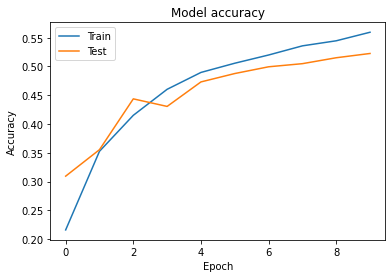

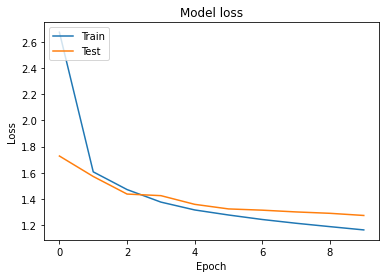

In [156]:
x = np.append(comp_1he.to_numpy(), prod_1he.to_numpy(),axis=1)
x = np.append(transformed, x, axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

#### Conclusions of PoC

At this point we are able to conclude the following:
- The model seems to work quite well. We get an accuracy of about 50% with a standard Keras model. It is worth to look further into this problem.
- We get the best performance using all chosen features. The company names are not as neccesary, it gives a marginal performance boost. However more data doesn't hurt

>**note**: Since we have a limited amount of time and we set ourselves an ambitious goal we will not focus that much on the accuracy of the model. We did this in previous sprints. During Sprint 3 we mainly want to complete the full end-to-end flow of machine learning.

## Making our solution available for actual users

As mentioned earlier, we will make use of the Google Cloud Platform in order to accomplish productionizing the model.

Our goal is that we can serve the prediction capabilities of our machine learning model trough an API endpoint. 

The following section describes the workflow we went through. However, not all code might be runnable since GCP requires authentication. The model however will be publicly addressable to show we actually accomplished our goal. 

### Tensorflow

In order to create a model that can be served on the GCP we will make use of the estimator API. The estimator API allows us to make use of canned estimators. We decided to use the canned estimators instead of creating our own estimator.

The estimator API takes away a lot of the complexity around productionizing a machine learning model. The concerns around distributed training etc. are handled for us. 

#### Creating feature columns

Feature columns define what types of features we will work with. (We experimented with feature crosses to make use of memorization. However, this did not improve our model so we left it out in the end.)

In [0]:
def get_feature_columns():
    return [
        # tf.feature_column.crossed_column(['Product', 'Company'], len(COMP_VOCAB) * len(PROD_VOCAB))
        # one hot encoding of the categorical product column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Product', PROD_VOCAB)),
        # one hot encoding of the categorical company column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Company', COMP_VOCAB)),
        # embedding of text using premade model 
        hub.text_embedding_column('Message', module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
    ]

> **Note**: We used a premade model for text embedding. Originally, we wanted to use Doc2Vec like we did in the PoC but we did not know how.


#### Input functions

We need to define input functions so that our model uses the right data in the right situation. Also, an extra input function needs to be created that defines how the deployed model should handle input.

The following function details how the batch datasets should be created from csv files:

In [0]:
def get_dataset(file_path, tf_mode, batch_size=512):
    def _input_fn():
    
        if tf_mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None
            shuffle=True
            shuffle_buffer_size=10*batch_size
        else:
            num_epochs = 1
            shuffle=False
            shuffle_buffer_size=None

        return tf.data.experimental.make_csv_dataset(
          file_path,
          batch_size=batch_size, 
          label_name=TARGET_LABEL,
          num_epochs=num_epochs,
          shuffle=shuffle,
          shuffle_buffer_size=shuffle_buffer_size
        )

    return _input_fn

These 3 functions create the required input_fn functions based upon the chosen scenario:

In [0]:
def get_train_input_fn():
    return get_dataset('./preproc/balanced_train_larger.csv', tf.estimator.ModeKeys.TRAIN)

def get_eval_input_fn():
    return get_dataset('./preproc/eval_data.csv', tf.estimator.ModeKeys.EVAL)
  
def get_test_input_fn():
    return get_dataset('./preproc/test_data.csv', tf.estimator.ModeKeys.PREDICT)

An extra input function needs to be created that tells the model how it should handle input when the model is served:

In [0]:
def get_serve_input_fn():

  # We'll receive 3 inputs, all of them are strings
    feat_placeholders = {
      'Product' : tf.placeholder(tf.string, [None]), 
      'Company' : tf.placeholder(tf.string, [None]), 
      'Message' : tf.placeholder(tf.string, [None])
    }

    features = feat_placeholders

    return tf.estimator.export.ServingInputReceiver(features, feat_placeholders)

#### Experimenting with different types of models 


Since canned estimators allow us to try different types of models relatively easy, we decided to try three different models. 


##### Linear model 

The first model we tried was a Linear Classifier.

In [0]:
# Train and evaluate with canned estimator
def train_and_evaluate_lin(model_dir, steps):

    # This ensures that eval points can be created for tensorboard analysis
    #tf.summary.FileWriterCache.clear()

    # Configuration of the run (commented lines determine the amount of eval points created)
    run_config = tf.estimator.RunConfig(
        model_dir = model_dir, 
        #save_summary_steps=100, 
        #save_checkpoints_steps=100
    )

    # Create the estimator
    estimator = tf.estimator.LinearClassifier(
        config = run_config,
        feature_columns = get_feature_columns(), 
        n_classes = len(ISS_VOCAB),
        label_vocabulary=ISS_VOCAB
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
        input_fn = get_train_input_fn(),
        max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
        input_fn = get_eval_input_fn(),
        exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Let's train this model:

In [16]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
OUTDIR = 'linear_model'
shutil.rmtree(OUTDIR, ignore_errors=True)
train_and_evaluate_lin(OUTDIR, 2000)

INFO:tensorflow:Using config: {'_model_dir': 'linear_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f451165f780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'linear_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f451165f780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into linear_model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into linear_model/model.ckpt.


INFO:tensorflow:loss = 2013.0939, step = 1


INFO:tensorflow:loss = 2013.0939, step = 1


INFO:tensorflow:global_step/sec: 21.6526


INFO:tensorflow:global_step/sec: 21.6526


INFO:tensorflow:loss = 102.26984, step = 101 (4.623 sec)


INFO:tensorflow:loss = 102.26984, step = 101 (4.623 sec)


INFO:tensorflow:global_step/sec: 19.6284


INFO:tensorflow:global_step/sec: 19.6284


INFO:tensorflow:loss = 257.63782, step = 201 (5.094 sec)


INFO:tensorflow:loss = 257.63782, step = 201 (5.094 sec)


INFO:tensorflow:global_step/sec: 19.9852


INFO:tensorflow:global_step/sec: 19.9852


INFO:tensorflow:loss = 536.1742, step = 301 (5.010 sec)


INFO:tensorflow:loss = 536.1742, step = 301 (5.010 sec)


INFO:tensorflow:global_step/sec: 20.3767


INFO:tensorflow:global_step/sec: 20.3767


INFO:tensorflow:loss = 239.01494, step = 401 (4.899 sec)


INFO:tensorflow:loss = 239.01494, step = 401 (4.899 sec)


INFO:tensorflow:global_step/sec: 22.035


INFO:tensorflow:global_step/sec: 22.035


INFO:tensorflow:loss = 806.36414, step = 501 (4.539 sec)


INFO:tensorflow:loss = 806.36414, step = 501 (4.539 sec)


INFO:tensorflow:global_step/sec: 22.0491


INFO:tensorflow:global_step/sec: 22.0491


INFO:tensorflow:loss = 88.04238, step = 601 (4.537 sec)


INFO:tensorflow:loss = 88.04238, step = 601 (4.537 sec)


INFO:tensorflow:global_step/sec: 18.7532


INFO:tensorflow:global_step/sec: 18.7532


INFO:tensorflow:loss = 155.47095, step = 701 (5.330 sec)


INFO:tensorflow:loss = 155.47095, step = 701 (5.330 sec)


INFO:tensorflow:global_step/sec: 19.5243


INFO:tensorflow:global_step/sec: 19.5243


INFO:tensorflow:loss = 85.31258, step = 801 (5.123 sec)


INFO:tensorflow:loss = 85.31258, step = 801 (5.123 sec)


INFO:tensorflow:global_step/sec: 20.5884


INFO:tensorflow:global_step/sec: 20.5884


INFO:tensorflow:loss = 733.8917, step = 901 (4.858 sec)


INFO:tensorflow:loss = 733.8917, step = 901 (4.858 sec)


INFO:tensorflow:global_step/sec: 22.2668


INFO:tensorflow:global_step/sec: 22.2668


INFO:tensorflow:loss = 258.0144, step = 1001 (4.491 sec)


INFO:tensorflow:loss = 258.0144, step = 1001 (4.491 sec)


INFO:tensorflow:global_step/sec: 22.0528


INFO:tensorflow:global_step/sec: 22.0528


INFO:tensorflow:loss = 180.45056, step = 1101 (4.535 sec)


INFO:tensorflow:loss = 180.45056, step = 1101 (4.535 sec)


INFO:tensorflow:global_step/sec: 19.0132


INFO:tensorflow:global_step/sec: 19.0132


INFO:tensorflow:loss = 165.91916, step = 1201 (5.258 sec)


INFO:tensorflow:loss = 165.91916, step = 1201 (5.258 sec)


INFO:tensorflow:global_step/sec: 19.5309


INFO:tensorflow:global_step/sec: 19.5309


INFO:tensorflow:loss = 108.40801, step = 1301 (5.123 sec)


INFO:tensorflow:loss = 108.40801, step = 1301 (5.123 sec)


INFO:tensorflow:global_step/sec: 20.3357


INFO:tensorflow:global_step/sec: 20.3357


INFO:tensorflow:loss = 287.7892, step = 1401 (4.917 sec)


INFO:tensorflow:loss = 287.7892, step = 1401 (4.917 sec)


INFO:tensorflow:global_step/sec: 21.7148


INFO:tensorflow:global_step/sec: 21.7148


INFO:tensorflow:loss = 66.41612, step = 1501 (4.606 sec)


INFO:tensorflow:loss = 66.41612, step = 1501 (4.606 sec)


INFO:tensorflow:global_step/sec: 21.9913


INFO:tensorflow:global_step/sec: 21.9913


INFO:tensorflow:loss = 211.69897, step = 1601 (4.544 sec)


INFO:tensorflow:loss = 211.69897, step = 1601 (4.544 sec)


INFO:tensorflow:global_step/sec: 19.101


INFO:tensorflow:global_step/sec: 19.101


INFO:tensorflow:loss = 161.26776, step = 1701 (5.239 sec)


INFO:tensorflow:loss = 161.26776, step = 1701 (5.239 sec)


INFO:tensorflow:global_step/sec: 19.7586


INFO:tensorflow:global_step/sec: 19.7586


INFO:tensorflow:loss = 114.39036, step = 1801 (5.059 sec)


INFO:tensorflow:loss = 114.39036, step = 1801 (5.059 sec)


INFO:tensorflow:global_step/sec: 21.337


INFO:tensorflow:global_step/sec: 21.337


INFO:tensorflow:loss = 287.15298, step = 1901 (4.686 sec)


INFO:tensorflow:loss = 287.15298, step = 1901 (4.686 sec)


INFO:tensorflow:Saving checkpoints for 2000 into linear_model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into linear_model/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-31T07:08:20Z


INFO:tensorflow:Starting evaluation at 2020-05-31T07:08:20Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from linear_model/model.ckpt-2000


INFO:tensorflow:Restoring parameters from linear_model/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Finished evaluation at 2020-05-31-07:08:24


INFO:tensorflow:Finished evaluation at 2020-05-31-07:08:24


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.16294008, average_loss = 4.6950755, global_step = 2000, loss = 2400.4192


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.16294008, average_loss = 4.6950755, global_step = 2000, loss = 2400.4192


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: linear_model/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: linear_model/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:Restoring parameters from linear_model/model.ckpt-2000


INFO:tensorflow:Restoring parameters from linear_model/model.ckpt-2000


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: linear_model/export/exporter/temp-b'1590908905'/assets


INFO:tensorflow:Assets written to: linear_model/export/exporter/temp-b'1590908905'/assets


INFO:tensorflow:SavedModel written to: linear_model/export/exporter/temp-b'1590908905'/saved_model.pb


INFO:tensorflow:SavedModel written to: linear_model/export/exporter/temp-b'1590908905'/saved_model.pb


INFO:tensorflow:Loss for final step: 58.4161.


INFO:tensorflow:Loss for final step: 58.4161.


Let's evaluate this model:

In [17]:
estimator = tf.estimator.LinearClassifier(
    model_dir='linear_model',
    feature_columns = get_feature_columns(), 
    n_classes = len(ISS_VOCAB),
    label_vocabulary=list(ISS_VOCAB)
)

estimator.evaluate(get_test_input_fn())

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'linear_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4518256b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'linear_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4518256b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-31T07:08:27Z


INFO:tensorflow:Starting evaluation at 2020-05-31T07:08:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from linear_model/model.ckpt-2000


INFO:tensorflow:Restoring parameters from linear_model/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-05-31-07:08:32


INFO:tensorflow:Finished evaluation at 2020-05-31-07:08:32


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1634649, average_loss = 4.691047, global_step = 2000, loss = 2398.2114


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.1634649, average_loss = 4.691047, global_step = 2000, loss = 2398.2114


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: linear_model/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: linear_model/model.ckpt-2000


{'accuracy': 0.1634649,
 'average_loss': 4.691047,
 'global_step': 2000,
 'loss': 2398.2114}

This model achieves an accuracy of about 16% (a random model would be about 2%).

##### Deep Neural Network model 

The second model we tried was a Deep Neural Network Classifier with a similar construction to our PoC DNN.

In [0]:
def train_and_evaluate_dnn(model_dir, steps):

    tf.summary.FileWriterCache.clear()

    run_config = tf.estimator.RunConfig(
        model_dir = model_dir, 
        #save_summary_steps=100,
        #save_checkpoints_steps=100
    )

  # Create the estimator
    estimator = tf.estimator.DNNClassifier(
        hidden_units = [256, 256], 
        feature_columns = get_feature_columns(), 
        config = run_config,
        n_classes= len(list(ISS_VOCAB)), 
        label_vocabulary=list(ISS_VOCAB), 
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
         input_fn = get_train_input_fn(),
         max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
        input_fn = get_eval_input_fn(),
        exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Let's train the model:

In [19]:
OUTDIR = 'deep_neural_network'
shutil.rmtree(OUTDIR, ignore_errors=True) 
train_and_evaluate_dnn(OUTDIR, 2000)

INFO:tensorflow:Using config: {'_model_dir': 'deep_neural_network', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4511279128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'deep_neural_network', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4511279128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into deep_neural_network/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into deep_neural_network/model.ckpt.


INFO:tensorflow:loss = 2002.8794, step = 1


INFO:tensorflow:loss = 2002.8794, step = 1


INFO:tensorflow:global_step/sec: 12.0789


INFO:tensorflow:global_step/sec: 12.0789


INFO:tensorflow:loss = 52.55445, step = 101 (8.281 sec)


INFO:tensorflow:loss = 52.55445, step = 101 (8.281 sec)


INFO:tensorflow:global_step/sec: 11.3978


INFO:tensorflow:global_step/sec: 11.3978


INFO:tensorflow:loss = 326.17334, step = 201 (8.774 sec)


INFO:tensorflow:loss = 326.17334, step = 201 (8.774 sec)


INFO:tensorflow:global_step/sec: 11.4568


INFO:tensorflow:global_step/sec: 11.4568


INFO:tensorflow:loss = 345.41183, step = 301 (8.729 sec)


INFO:tensorflow:loss = 345.41183, step = 301 (8.729 sec)


INFO:tensorflow:global_step/sec: 11.6482


INFO:tensorflow:global_step/sec: 11.6482


INFO:tensorflow:loss = 164.0144, step = 401 (8.585 sec)


INFO:tensorflow:loss = 164.0144, step = 401 (8.585 sec)


INFO:tensorflow:global_step/sec: 12.1982


INFO:tensorflow:global_step/sec: 12.1982


INFO:tensorflow:loss = 311.17682, step = 501 (8.199 sec)


INFO:tensorflow:loss = 311.17682, step = 501 (8.199 sec)


INFO:tensorflow:global_step/sec: 12.0778


INFO:tensorflow:global_step/sec: 12.0778


INFO:tensorflow:loss = 12.422424, step = 601 (8.278 sec)


INFO:tensorflow:loss = 12.422424, step = 601 (8.278 sec)


INFO:tensorflow:global_step/sec: 11.1431


INFO:tensorflow:global_step/sec: 11.1431


INFO:tensorflow:loss = 123.69534, step = 701 (8.975 sec)


INFO:tensorflow:loss = 123.69534, step = 701 (8.975 sec)


INFO:tensorflow:global_step/sec: 11.3338


INFO:tensorflow:global_step/sec: 11.3338


INFO:tensorflow:loss = 24.404345, step = 801 (8.822 sec)


INFO:tensorflow:loss = 24.404345, step = 801 (8.822 sec)


INFO:tensorflow:global_step/sec: 11.6928


INFO:tensorflow:global_step/sec: 11.6928


INFO:tensorflow:loss = 291.79138, step = 901 (8.554 sec)


INFO:tensorflow:loss = 291.79138, step = 901 (8.554 sec)


INFO:tensorflow:global_step/sec: 12.1272


INFO:tensorflow:global_step/sec: 12.1272


INFO:tensorflow:loss = 42.479965, step = 1001 (8.247 sec)


INFO:tensorflow:loss = 42.479965, step = 1001 (8.247 sec)


INFO:tensorflow:global_step/sec: 12.1205


INFO:tensorflow:global_step/sec: 12.1205


INFO:tensorflow:loss = 123.804474, step = 1101 (8.250 sec)


INFO:tensorflow:loss = 123.804474, step = 1101 (8.250 sec)


INFO:tensorflow:global_step/sec: 11.1355


INFO:tensorflow:global_step/sec: 11.1355


INFO:tensorflow:loss = 143.30138, step = 1201 (8.981 sec)


INFO:tensorflow:loss = 143.30138, step = 1201 (8.981 sec)


INFO:tensorflow:global_step/sec: 11.3052


INFO:tensorflow:global_step/sec: 11.3052


INFO:tensorflow:loss = 42.589447, step = 1301 (8.842 sec)


INFO:tensorflow:loss = 42.589447, step = 1301 (8.842 sec)


INFO:tensorflow:global_step/sec: 11.746


INFO:tensorflow:global_step/sec: 11.746


INFO:tensorflow:loss = 241.31898, step = 1401 (8.513 sec)


INFO:tensorflow:loss = 241.31898, step = 1401 (8.513 sec)


INFO:tensorflow:global_step/sec: 11.9937


INFO:tensorflow:global_step/sec: 11.9937


INFO:tensorflow:loss = 15.242254, step = 1501 (8.338 sec)


INFO:tensorflow:loss = 15.242254, step = 1501 (8.338 sec)


INFO:tensorflow:global_step/sec: 12.0484


INFO:tensorflow:global_step/sec: 12.0484


INFO:tensorflow:loss = 154.5635, step = 1601 (8.303 sec)


INFO:tensorflow:loss = 154.5635, step = 1601 (8.303 sec)


INFO:tensorflow:global_step/sec: 11.0909


INFO:tensorflow:global_step/sec: 11.0909


INFO:tensorflow:loss = 166.57251, step = 1701 (9.016 sec)


INFO:tensorflow:loss = 166.57251, step = 1701 (9.016 sec)


INFO:tensorflow:global_step/sec: 11.3225


INFO:tensorflow:global_step/sec: 11.3225


INFO:tensorflow:loss = 33.59063, step = 1801 (8.833 sec)


INFO:tensorflow:loss = 33.59063, step = 1801 (8.833 sec)


INFO:tensorflow:global_step/sec: 11.8133


INFO:tensorflow:global_step/sec: 11.8133


INFO:tensorflow:loss = 267.76923, step = 1901 (8.462 sec)


INFO:tensorflow:loss = 267.76923, step = 1901 (8.462 sec)


INFO:tensorflow:Saving checkpoints for 2000 into deep_neural_network/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into deep_neural_network/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-31T07:14:35Z


INFO:tensorflow:Starting evaluation at 2020-05-31T07:14:35Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from deep_neural_network/model.ckpt-2000


INFO:tensorflow:Restoring parameters from deep_neural_network/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Finished evaluation at 2020-05-31-07:14:42


INFO:tensorflow:Finished evaluation at 2020-05-31-07:14:42


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.04622195, average_loss = 15.736079, global_step = 2000, loss = 8045.278


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.04622195, average_loss = 15.736079, global_step = 2000, loss = 8045.278


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: deep_neural_network/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: deep_neural_network/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:Restoring parameters from deep_neural_network/model.ckpt-2000


INFO:tensorflow:Restoring parameters from deep_neural_network/model.ckpt-2000


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: deep_neural_network/export/exporter/temp-b'1590909282'/assets


INFO:tensorflow:Assets written to: deep_neural_network/export/exporter/temp-b'1590909282'/assets


INFO:tensorflow:SavedModel written to: deep_neural_network/export/exporter/temp-b'1590909282'/saved_model.pb


INFO:tensorflow:SavedModel written to: deep_neural_network/export/exporter/temp-b'1590909282'/saved_model.pb


INFO:tensorflow:Loss for final step: 11.785759.


INFO:tensorflow:Loss for final step: 11.785759.


Let's evaluate the model:

In [20]:
estimator = tf.estimator.DNNClassifier(
    hidden_units = [256, 256], 
    feature_columns = get_feature_columns(), 
    model_dir = OUTDIR, 
    n_classes= len(list(ISS_VOCAB)), 
    label_vocabulary=list(ISS_VOCAB), 
  )

estimator.evaluate(get_test_input_fn())

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'deep_neural_network', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4516f50e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'deep_neural_network', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4516f50e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-31T07:14:45Z


INFO:tensorflow:Starting evaluation at 2020-05-31T07:14:45Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from deep_neural_network/model.ckpt-2000


INFO:tensorflow:Restoring parameters from deep_neural_network/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-05-31-07:14:52


INFO:tensorflow:Finished evaluation at 2020-05-31-07:14:52


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.04573064, average_loss = 15.698022, global_step = 2000, loss = 8025.324


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.04573064, average_loss = 15.698022, global_step = 2000, loss = 8025.324


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: deep_neural_network/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: deep_neural_network/model.ckpt-2000


{'accuracy': 0.04573064,
 'average_loss': 15.698022,
 'global_step': 2000,
 'loss': 8025.324}

This model achieves an accuracy of about 5%. Because of the results in the Proof of Concept we anticipated a much better score. However, this is probably due to the fact that we were not able to use Doc2Vec here. 

##### Wide and Deep model 

We decided to try a third kind of model. A wide and deep model is a combination of a Linear type and DNN type model. It allows us to decide which features are better used in what kind of model.

In [0]:
# Create wide features (for linear part of model):
def get_wide_features():
    return [
      # tf.feature_column.crossed_column(['Product', 'Company'], len(PROD_VOCAB) * len(COMP_VOCAB))
      # one hot encoding of the categorical product column (using vocab)
      tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Product', PROD_VOCAB)),
      # one hot encoding of the categorical company column (using vocab)
      tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Company', COMP_VOCAB))
    ]

# Create deep features (for DNN part of model):
def get_deep_features():
    return [
      # embedding of text using premade model 
      hub.text_embedding_column('Message', module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
  ]

In [0]:
# Train and evaluate with canned estimator
def train_and_evaluate_wnd(model_dir, steps):

    tf.summary.FileWriterCache.clear()

  # Create the estimator
    estimator = tf.estimator.DNNLinearCombinedClassifier(
        model_dir=model_dir, 
        linear_feature_columns=get_wide_features(), 
        dnn_feature_columns=get_deep_features(),  
        dnn_hidden_units=[256,256],
        n_classes=len(list(ISS_VOCAB)), 
        label_vocabulary=list(ISS_VOCAB), 
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
        input_fn = get_train_input_fn(),
        max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
        input_fn = get_eval_input_fn(),
        exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Let's train the model:



In [24]:
OUTDIR = 'wide_and_deep'
shutil.rmtree(OUTDIR, ignore_errors=True) 
train_and_evaluate_dnn(OUTDIR, 2000)

INFO:tensorflow:Using config: {'_model_dir': 'wide_and_deep', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4516d52390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'wide_and_deep', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4516d52390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into wide_and_deep/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into wide_and_deep/model.ckpt.


INFO:tensorflow:loss = 2017.4382, step = 1


INFO:tensorflow:loss = 2017.4382, step = 1


INFO:tensorflow:global_step/sec: 12.0901


INFO:tensorflow:global_step/sec: 12.0901


INFO:tensorflow:loss = 53.30283, step = 101 (8.275 sec)


INFO:tensorflow:loss = 53.30283, step = 101 (8.275 sec)


INFO:tensorflow:global_step/sec: 11.3881


INFO:tensorflow:global_step/sec: 11.3881


INFO:tensorflow:loss = 511.68414, step = 201 (8.782 sec)


INFO:tensorflow:loss = 511.68414, step = 201 (8.782 sec)


INFO:tensorflow:global_step/sec: 11.3141


INFO:tensorflow:global_step/sec: 11.3141


INFO:tensorflow:loss = 227.90274, step = 301 (8.835 sec)


INFO:tensorflow:loss = 227.90274, step = 301 (8.835 sec)


INFO:tensorflow:global_step/sec: 11.6641


INFO:tensorflow:global_step/sec: 11.6641


INFO:tensorflow:loss = 193.07036, step = 401 (8.576 sec)


INFO:tensorflow:loss = 193.07036, step = 401 (8.576 sec)


INFO:tensorflow:global_step/sec: 12.1891


INFO:tensorflow:global_step/sec: 12.1891


INFO:tensorflow:loss = 262.74335, step = 501 (8.203 sec)


INFO:tensorflow:loss = 262.74335, step = 501 (8.203 sec)


INFO:tensorflow:global_step/sec: 12.0538


INFO:tensorflow:global_step/sec: 12.0538


INFO:tensorflow:loss = 6.0094047, step = 601 (8.298 sec)


INFO:tensorflow:loss = 6.0094047, step = 601 (8.298 sec)


INFO:tensorflow:global_step/sec: 11.0964


INFO:tensorflow:global_step/sec: 11.0964


INFO:tensorflow:loss = 156.36086, step = 701 (9.010 sec)


INFO:tensorflow:loss = 156.36086, step = 701 (9.010 sec)


INFO:tensorflow:global_step/sec: 11.3586


INFO:tensorflow:global_step/sec: 11.3586


INFO:tensorflow:loss = 16.605362, step = 801 (8.805 sec)


INFO:tensorflow:loss = 16.605362, step = 801 (8.805 sec)


INFO:tensorflow:global_step/sec: 11.7056


INFO:tensorflow:global_step/sec: 11.7056


INFO:tensorflow:loss = 288.17407, step = 901 (8.542 sec)


INFO:tensorflow:loss = 288.17407, step = 901 (8.542 sec)


INFO:tensorflow:global_step/sec: 12.1129


INFO:tensorflow:global_step/sec: 12.1129


INFO:tensorflow:loss = 59.160755, step = 1001 (8.261 sec)


INFO:tensorflow:loss = 59.160755, step = 1001 (8.261 sec)


INFO:tensorflow:global_step/sec: 12.1433


INFO:tensorflow:global_step/sec: 12.1433


INFO:tensorflow:loss = 105.3094, step = 1101 (8.228 sec)


INFO:tensorflow:loss = 105.3094, step = 1101 (8.228 sec)


INFO:tensorflow:global_step/sec: 11.116


INFO:tensorflow:global_step/sec: 11.116


INFO:tensorflow:loss = 128.26431, step = 1201 (8.998 sec)


INFO:tensorflow:loss = 128.26431, step = 1201 (8.998 sec)


INFO:tensorflow:global_step/sec: 11.3322


INFO:tensorflow:global_step/sec: 11.3322


INFO:tensorflow:loss = 76.88522, step = 1301 (8.822 sec)


INFO:tensorflow:loss = 76.88522, step = 1301 (8.822 sec)


INFO:tensorflow:global_step/sec: 11.8131


INFO:tensorflow:global_step/sec: 11.8131


INFO:tensorflow:loss = 241.43307, step = 1401 (8.469 sec)


INFO:tensorflow:loss = 241.43307, step = 1401 (8.469 sec)


INFO:tensorflow:global_step/sec: 12.0177


INFO:tensorflow:global_step/sec: 12.0177


INFO:tensorflow:loss = 12.504532, step = 1501 (8.320 sec)


INFO:tensorflow:loss = 12.504532, step = 1501 (8.320 sec)


INFO:tensorflow:global_step/sec: 12.184


INFO:tensorflow:global_step/sec: 12.184


INFO:tensorflow:loss = 151.46532, step = 1601 (8.205 sec)


INFO:tensorflow:loss = 151.46532, step = 1601 (8.205 sec)


INFO:tensorflow:global_step/sec: 11.0949


INFO:tensorflow:global_step/sec: 11.0949


INFO:tensorflow:loss = 140.36855, step = 1701 (9.015 sec)


INFO:tensorflow:loss = 140.36855, step = 1701 (9.015 sec)


INFO:tensorflow:global_step/sec: 11.3703


INFO:tensorflow:global_step/sec: 11.3703


INFO:tensorflow:loss = 42.754227, step = 1801 (8.793 sec)


INFO:tensorflow:loss = 42.754227, step = 1801 (8.793 sec)


INFO:tensorflow:global_step/sec: 11.8991


INFO:tensorflow:global_step/sec: 11.8991


INFO:tensorflow:loss = 292.7226, step = 1901 (8.404 sec)


INFO:tensorflow:loss = 292.7226, step = 1901 (8.404 sec)


INFO:tensorflow:Saving checkpoints for 2000 into wide_and_deep/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2000 into wide_and_deep/model.ckpt.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-31T07:22:34Z


INFO:tensorflow:Starting evaluation at 2020-05-31T07:22:34Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from wide_and_deep/model.ckpt-2000


INFO:tensorflow:Restoring parameters from wide_and_deep/model.ckpt-2000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Finished evaluation at 2020-05-31-07:22:41


INFO:tensorflow:Finished evaluation at 2020-05-31-07:22:41


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.048198476, average_loss = 10.772164, global_step = 2000, loss = 5507.4106


INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.048198476, average_loss = 10.772164, global_step = 2000, loss = 5507.4106


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: wide_and_deep/model.ckpt-2000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: wide_and_deep/model.ckpt-2000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:


INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:'classification' : Classification input must be a single string Tensor; got {'Product': <tf.Tensor 'Placeholder:0' shape=(?,) dtype=string>, 'Company': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=string>, 'Message': <tf.Tensor 'Placeholder_2:0' shape=(?,) dtype=string>}


INFO:tensorflow:Restoring parameters from wide_and_deep/model.ckpt-2000


INFO:tensorflow:Restoring parameters from wide_and_deep/model.ckpt-2000


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: wide_and_deep/export/exporter/temp-b'1590909761'/assets


INFO:tensorflow:Assets written to: wide_and_deep/export/exporter/temp-b'1590909761'/assets


INFO:tensorflow:SavedModel written to: wide_and_deep/export/exporter/temp-b'1590909761'/saved_model.pb


INFO:tensorflow:SavedModel written to: wide_and_deep/export/exporter/temp-b'1590909761'/saved_model.pb


INFO:tensorflow:Loss for final step: 13.383623.


INFO:tensorflow:Loss for final step: 13.383623.


### Conclusion of experiments

Thanks to the PoC we know that 50% accuracy (for 50+ classes) can be achieved using a NN when Doc2Vec is used. If we knew how to use Doc2Vec we would be able to rebuild the full PoC as an DNNClassifier. Without Doc2Vec all three models have a lower accuracy than the model created in the PoC. 

Since we wanted to focus on productionizing the model, we decided to pick the best model out of the 3: LinearClassifier. And ignore the possible accuracy gains for now since this was the focus of previous sprints.


### Packaging the code

In order to train the model on GCP (which allows for hyperparameter tuning) we need to create a package. This requires the creation of 3 files.

#### `__init__.py`


In [28]:
%%bash
mkdir trainer
cp -r preproc ./trainer/

mkdir: cannot create directory ‘trainer’: File exists


In [29]:
%%writefile trainer/__init__.py

# empty

Writing trainer/__init__.py


#### model.py

This file defines the model that will be used

In [43]:
%%writefile trainer/model.py

import sys
import os 

import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import shutil

## DEFINING CONSTANTS

train_data = pd.read_csv('./preproc/train_data.csv')
eval_data = pd.read_csv('./preproc/eval_data.csv')
test_data = pd.read_csv('./preproc/test_data.csv')
balanced_train_small = pd.read_csv('./preproc/balanced_train_small.csv')
balanced_train_larger = pd.read_csv('./preproc/balanced_train_larger.csv')

CSV_COLUMNS = ['Product', 'Company', 'Message', 'Issue']
CSV_FEATURES = ['Product', 'Company', 'Message']
TARGET_LABEL = 'Issue'
DEFAULTS = [['Unknown'], ['Unknown'], ['Unknown']]

PROD_VOCAB = np.append(train_data['Product'].unique(), 'Unknown')
PROD_VOCAB = np.append(PROD_VOCAB, eval_data['Product'].unique())
PROD_VOCAB = np.append(PROD_VOCAB, test_data['Product'].unique())
PROD_VOCAB = list(set(PROD_VOCAB))

COMP_VOCAB = np.append(train_data['Company'].unique(), 'Unknown')
COMP_VOCAB = np.append(COMP_VOCAB, eval_data['Company'].unique())
COMP_VOCAB = np.append(COMP_VOCAB, test_data['Company'].unique())
COMP_VOCAB = list(set(COMP_VOCAB))

ISS_VOCAB = np.append(train_data['Issue'].unique(), 'Unknown')
ISS_VOCAB = np.append(ISS_VOCAB, eval_data['Issue'].unique())
ISS_VOCAB = np.append(ISS_VOCAB, test_data['Issue'].unique())
ISS_VOCAB = list(set(ISS_VOCAB))

BATCH_SIZE = 512

## FEATURE COLUMNS

def get_feature_columns():
    return [
        # tf.feature_column.crossed_column(['Product', 'Company'], len(COMP_VOCAB) * len(PROD_VOCAB))
        # one hot encoding of the categorical product column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Product', PROD_VOCAB)),
        # one hot encoding of the categorical company column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Company', COMP_VOCAB)),
        # embedding of text using premade model 
        hub.text_embedding_column('Message', module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
    ]

## INPUT FUNCTIONS

def get_dataset(file_path, tf_mode):
    def _input_fn():
    
        if tf_mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None
            shuffle=True
            shuffle_buffer_size=10*BATCH_SIZE
        else:
            num_epochs = 1
            shuffle=False
            shuffle_buffer_size=None

        return tf.data.experimental.make_csv_dataset(
          file_path,
          batch_size=BATCH_SIZE, 
          label_name=TARGET_LABEL,
          num_epochs=num_epochs,
          shuffle=shuffle,
          shuffle_buffer_size=shuffle_buffer_size
        )

    return _input_fn

def get_train_input_fn():
    return get_dataset('./preproc/balanced_train_larger.csv', tf.estimator.ModeKeys.TRAIN)

def get_eval_input_fn():
    return get_dataset('./preproc/eval_data.csv', tf.estimator.ModeKeys.EVAL)
  
def get_test_input_fn():
    return get_dataset('./preproc/test_data.csv', tf.estimator.ModeKeys.PREDICT)

def get_serve_input_fn():

  # We'll receive 3 inputs, all of them are strings
    feat_placeholders = {
      'Product' : tf.placeholder(tf.string, [None]), 
      'Company' : tf.placeholder(tf.string, [None]), 
      'Message' : tf.placeholder(tf.string, [None])
    }

    features = feat_placeholders

    return tf.estimator.export.ServingInputReceiver(features, feat_placeholders)

# Train and evaluate with canned estimator
def train_and_evaluate_lin(model_dir, steps):

    # This ensures that eval points can be created for tensorboard analysis
    #tf.summary.FileWriterCache.clear()

    # Configuration of the run (commented lines determine the amount of eval points created)
    run_config = tf.estimator.RunConfig(
        model_dir = model_dir, 
        #save_summary_steps=100, 
        #save_checkpoints_steps=100
    )

    # Create the estimator
    estimator = tf.estimator.LinearClassifier(
        config = run_config,
        feature_columns = get_feature_columns(), 
        n_classes = len(ISS_VOCAB),
        label_vocabulary=ISS_VOCAB
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
        input_fn = get_train_input_fn(),
        max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
        input_fn = get_eval_input_fn(),
        exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Overwriting trainer/model.py


#### trainer.py

This file parses the arguments and starts the specified task.

In [36]:
%%writefile trainer/task.py

import argparse
import json
import os

from . import model

if __name__ == '__main__':
  
    parser = argparse.ArgumentParser()

    parser.add_argument(
        '--model_dir',
        help = "Output folder for the model",
        required = True
    )
    parser.add_argument(
        '--train_steps',
        help = 'Amount of training steps',
        type = int,
        default = 2000
    )
    parser.add_argument(
        '--batch_size',
        help = 'The size of the batches.',
        type = int,
        default=512
    )

    args = parser.parse_args()
    arguments = args.__dict__

    arguments.pop('job_dir', None)
    arguments.pop('job-dir', None)

    output_dir = arguments.pop('model_dir')
    steps = arguments.pop('train_steps')
    model.BATCH_SIZE = arguments.pop('batch_size')

    output_dir = os.path.join(
    output_dir, 
    json.loads(
      os.environ.get('TF_CONFIG', '{}')
    ).get('task', {}).get('trail', '')
    )

  
  model.train_and_evaluate_lin(output_dir, steps)

Overwriting trainer/task.py


These 3 files make up the package. We executed the module locally to check if everything works properly:

In [44]:
!python -m trainer.task --model_dir=trained --train_steps=1

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updat

The trained folder gets created and contains the model. Everything works as expected.

### Research into hyperparameter tuning

GCP allows for easy and optimized hyperparameter tuning. We didn't want to focus on the accuracy of the model. 

However, we wanted to try this because we wanted to know how to do it for future reference.

>**note**: In the end we only documented how to do this. Because of the cost we opted not to execute the tuning.

The first thing we needed to do was to create a yaml file containing all possible options:

In [0]:
%%writefile trainer/tune.yaml

trainingInput:
    scaleTier: STANDARD_1
    hyperparameters:
        hyperparameterMetricTag: # You need to define this
        goal: MINIMIZE
        maxTrials: 20
        maxParallelTrials: 5
        enableTrialEarlyStopping: True
        params:
        - parameterName: batch_size
            type: INTEGER
            minValue: 8
            maxValue: 512
            scaleType: UNIT_LOG_SCALE
        - parameterName: nnsize
            type: INTEGER
            minValue: 64
            maxValue: 512
            scaleType: UNIT_LOG_SCALE

Writing trainer/tune.yaml


This command should run the hyperparameter tuning for us:

In [0]:
gcloud ai-platform jobs submit training hype_training \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=. \
  --job-dir=trained \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --config=tune.yaml \
  --runtime-version=$TFVERSION \
  -- \
  --model_dir=trained \

### Deploying the trained model

Now that we know the package works, we can deploy it to GCP.

Since we trained locally already during the previous steps there is no need to train again. However, we'll do it again this time using the ai-platform local command for completeness:

In [48]:
%%bash
gcloud config set ml_engine/local_python /usr/bin/python3
gcloud ai-platform local train \
  --module-name=trainer.task \
  --package-path=trainer \
  -- \
  --model_dir=trained

Updated property [ml_engine/local_python].
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the f

The resulting locally trained model is stored locally. We need to upload the trained model to GC Storage so that we can create an ai-platform model from it.

In [62]:
%%bash
FOLDER=$(ls trained/export/exporter | tail -n 1)
echo ${FOLDER}
gsutil rm -R gs://$BUCKET/trained
gsutil -m cp -R trained/export/exporter/${FOLDER} gs://$BUCKET/trained

1590911004


CommandException: No URLs matched: gs://applied_machine_learning_bucket/trained
Copying file://trained/export/exporter/1590911004/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://trained/export/exporter/1590911004/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
Copying file://trained/export/exporter/1590911004/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://trained/export/exporter/1590911004/assets/tokens.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such obje

Let's check if the transfer was successful:

In [63]:
!gsutil ls gs://$BUCKET/trained

gs://applied_machine_learning_bucket/trained/saved_model.pb
gs://applied_machine_learning_bucket/trained/assets/
gs://applied_machine_learning_bucket/trained/variables/


The following steps require authentication of my account. These steps are given for documentation purposes.

Use oauth2 authentication:

In [56]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=G9L8vKMd6iQKf20_KoCSWQtDC_g2VzIgNTD-95IRR6I&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/0QEtMFKebYPfn3Td403jse5GKjc_VEcsuE-zwt2fsV92xwUE6W4tU0I

You are now logged in as [desmettim@outlook.com].
Your current project is [appliedml-270208].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


If notebook was executed previously the commented commands can remove the version of the model and the model itself.

When no model is present, we create the new model called sprint3:

In [71]:
#!gcloud ai-platform versions delete final --model sprint3
#!gcloud ai-platform models delete sprint3
!gcloud ai-platform models create sprint3

This will delete version [final]...

Do you want to continue (Y/n)?  Y

This will delete model [sprint3]...

Do you want to continue (Y/n)?  Y


Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Created ml engine model [projects/appliedml-270208/models/sprint3].


Every model works based upon a specific version. The following command creates the final version for the sprint 3 model from the trained model stored in GCS:

In [72]:
!gcloud ai-platform versions create final  --model sprint3 --origin gs://$BUCKET/trained --runtime-version 1.15 --framework tensorflow

### Making predictions

At this point we have a model in production. Now we need to test if we can actually make predictions using our deployed model.

Let's retrieve an instance: 

In [74]:
# Use test data:
test_data = pd.read_csv('./preproc/test_data.csv')
print(test_data.iloc[0])

Product                                      Debt collection
Company                                         AmeriCollect
Message    americollect inc account number attent disput ...
Issue                  Cont'd attempts collect debt not owed
Name: 0, dtype: object


We can use a json file to pass the data to the model. We create the file with the data we want a prediction for:

In [75]:
%%writefile test.json
{"Product":"Vehicle loan or lease","Company":"CREDIT ACCEPTANCE CORPORATION","Message":"car purchas payment month call compani make arrang pay month rep state day work u said later month respons problem start call state made arrang pay told problem rep phone said one told problem month pay car made payment call say pass due late fee take car state never told late fee rep said problem said pay next payment due hard time said well continu call u said call time day hung"}

Writing test.json


We use the test.json file to request a prediction from our sprint3 model:

In [76]:
!gcloud ai-platform predict --model=sprint3 --json-instances=test.json

ALL_CLASS_IDS                                                                                                                                                                                       ALL_CLASSES                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

We get the following answer:

**all class ids**:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]  

**all class names**:
[u'Credit monitoring or identity theft protection services', u'False statements or representation', u'Attempts to collect debt not owed', u'Improper use of your report', u"Problem with a credit reporting company's investigation into an existing problem", u'Incorrect information on your report', u'Unknown', u'Trouble during payment process', u'Fees or interest', u'Communication tactics', u'Took or threatened to take negative or legal action', u'Written notification about debt', u'Dealing with your lender or servicer', u'Problem with fraud alerts or security freezes', u'Fraud or scam', u'Closing on a mortgage', u'Threatened to contact someone or share information improperly', u'Struggling to pay your loan', u'Unable to get your credit report or credit score', u'Closing an account', u'Problem with a purchase shown on your statement', u'Closing your account', u'Advertising and marketing, including promotional offers', u'Managing an account', u'Getting a credit card', u'Opening an account', u'Other features, terms, or problems', u'Struggling to pay mortgage', u'Managing the loan or lease', u'Problem with a lender or other company charging your account', u'Struggling to repay your loan', u'Problem when making payments', u'Applying for a mortgage or refinancing an existing mortgage', u'Loan servicing, payments, escrow account', u'Loan modification,collection,foreclosure', u'Taking/threatening an illegal action', u'Settlement process and costs', u"Cont'd attempts collect debt not owed", u'Disclosure verification of debt', u"Can't repay my loan", u'Account opening, closing, or management', u'Incorrect information on credit report', u'Billing disputes', u'Dealing with my lender or servicer', u'Unable to get credit report/credit score', u"Credit reporting company's investigation", u'Problems when you are unable to pay', u'Application, originator, mortgage broker', u'Improper contact or sharing of info', u'Problems caused by my funds being low', u'Deposits and withdrawals'] 


**chosen class id**: [17]       


**chosen class**: [u'Struggling to pay your loan']  

**logits**:
[-2.0418670177459717, -16.874784469604492, -9.737305641174316, -7.570767879486084, -5.339376926422119, -5.096161365509033, -4.203519821166992, -6.723516464233398, -6.306142330169678, -7.633228778839111, -16.874784469604492, -16.874784469604492, -16.874784469604492, -7.850489139556885, -8.056821823120117, -9.85521411895752, -8.225409507751465, -1.017134666442871, -10.442292213439941, -8.277178764343262, -16.874784469604492, -8.440375328063965, -7.760432720184326, -16.874784469604492, -9.989632606506348, -10.289300918579102, -7.3494768142700195, -16.874784469604492, -16.874784469604492, -7.328330993652344, -8.548629760742188, -6.064115047454834, -10.25114631652832, -3.9535467624664307, -16.874784469604492, -5.590899467468262, -8.161460876464844, -7.742534637451172, -16.874784469604492, -4.920774936676025, -16.874784469604492, -7.966688632965088, -5.45908260345459, -16.874784469604492, -9.322630882263184, -9.244152069091797, -2.489431142807007, -9.500584602355957, -8.012287139892578, -6.850594520568848, -7.723545551300049] 


**probabilities**:
[0.20033806562423706, 7.242847033239741e-08, 9.113327541854233e-05, 0.0007954124012030661, 0.007407525088638067, 0.00944713968783617, 0.023065859451889992, 0.001855876063928008, 0.0028171648737043142, 0.0007472499855794013, 7.242847033239741e-08, 7.242847033239741e-08, 7.242847033239741e-08, 0.0006013273377902806, 0.0004892172873951495, 8.09971897979267e-05, 0.00041331874672323465, 0.5582119226455688, 4.5030337787466124e-05, 0.0003924659686163068, 7.242847033239741e-08, 0.0003333701170049608, 0.0006579940090887249, 7.242847033239741e-08, 7.080970681272447e-05, 5.2474522817647085e-05, 0.00099242536816746, 7.242847033239741e-08, 7.242847033239741e-08, 0.0010136344935745, 0.00029916607309132814, 0.0035885863471776247, 5.451534889289178e-05, 0.029616352170705795, 7.242847033239741e-08, 0.005760209634900093, 0.0004406133375596255, 0.0006698769284412265, 7.242847033239741e-08, 0.011258219368755817, 7.242847033239741e-08, 0.0005353603046387434, 0.006571819540113211, 7.242847033239741e-08, 0.00013796468556392938, 0.00014922817354090512, 0.1280527412891388, 0.00011547384201548994, 0.0005114969098940492, 0.001634404994547367, 0.0006827187607996166]




### Using the API

The following step only works when running in the Google Compute Engine since credentials are required. The step is given for documentation purposes. It details how we can send requests to the API:

In [0]:
from oauth2client.client import GoogleCredentials
import requests
import json

MODEL_NAME='sprint3'
MODEL_VERSION='final'

token = GoogleCredentials.get_application_default().get_access_token().access_token
api = 'https://ml.googleapis.com/v1/projects/{}/models/{}/versions/{}:predict'.format(PROJECT, MODEL_NAME, MODEL_VERSION)
print(api)
headers = {'Authorization' : 'Bearer ' + token}

data = {
    'instances' : [{
        "Product":"Vehicle loan or lease",
        "Company":"CREDIT ACCEPTANCE CORPORATION",
        "Message":"car purchas payment month call compani make arrang pay month rep state day work u said later month respons problem start call state made arrang pay told problem rep phone said one told problem month pay car made payment call say pass due late fee take car state never told late fee rep said problem said pay next payment due hard time said well continu call u said call time day hung"}
    ]
}

response = requests.post(api, json=data, headers=headers)
print(response.content)

We were able to create a machine learning model and host it for predictions.